In [6]:
import fasttext
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [7]:
fasttext.FastText.eprint = lambda x: None # suppress warnings

In [8]:
df_train = pd.read_csv("data_v0.3_train.csv")
df_val = pd.read_csv("data_v0.3_val.csv")

In [9]:
df_train.columns

Index(['entry_id', 'excerpt', 'analysis_framework_id', 'created_by_id',
       'lead_id', 'modified_by_id', 'information_date', 'order', 'client_id',
       'project_id', 'tabular_field_id', 'dropped_excerpt', 'verified',
       'verification_last_changed_by_id', 'exportdata_id', 'exportable_id',
       'dimensions', 'subdimensions', 'sectors', 'subsectors', 'Shelter',
       'Livelihoods', 'Protection', 'Shelter and NFIs', 'NFI', 'Food Security',
       'Logistics', 'Cross', 'CCCM', 'Agriculture', 'Health', 'Nutrition',
       'Education', 'WASH', 'sector_ids', 'Shock Informaton',
       'Effects Systems And Networks', 'Effects On Population',
       'Capacities & Response', 'At Risk', 'Scope & Scale', 'Impact',
       'Humanitarian Conditions', 'Priorities', 'Context', 'dimension_ids'],
      dtype='object')

In [10]:
!mkdir ft_data

mkdir: cannot create directory ‘ft_data’: File exists


In [22]:
def write_data(X, y, path):
    with open(path, "w") as f:
        for xi, yi in zip(X, y):
            f.write(f"__label__{yi} {xi}\n")


##
def ft_pred(model, X):
    preds = model.predict(X)
    return [int(p[0][9:]) for p in preds[0]]


##
def ft_pred_proba(model, X):
    preds = model.predict(X)
    return [p[0] for p in preds[1]]


##
def train_and_pred_on_class(df_train, df_val, class_name):
    X_train, y_train = df_train["excerpt"].tolist(
    ), df_train[class_name].tolist()
    X_val, y_val = df_val["excerpt"].tolist(), df_val[class_name].tolist()
    path_train = f"ft_data/{class_name}_train.txt"
    path_val = f"ft_data/{class_name}_val.txt"
    write_data(X_train, y_train, path_train)
    write_data(X_val, y_val, path_val)
    model = fasttext.train_supervised(input=path_train)
    preds_train = ft_pred(model, X_train)
    preds_val = ft_pred(model, X_val)
    return {
        "y_train": y_train,
        "y_val": y_val,
        "preds_train": preds_train,
        "preds_val": preds_val
    }


def metrics(train_outputs):
    recalls_train, precisions_train, f1_scores_train, supports_train, accuracies_train = [], [], [], [], []
    recalls_val, precisions_val, f1_scores_val, supports_val, accuracies_val = [], [], [], [], []
    class_names = []
    for class_name, train_output in train_outputs.items():
        class_names.append(class_name)
        ##
        cls_rprt = classification_report(train_output["y_train"],
                                         train_output["preds_train"],
                                         output_dict=True)
        precisions_train.append(cls_rprt["macro avg"]["precision"])
        recalls_train.append(cls_rprt["macro avg"]["recall"])
        f1_scores_train.append(cls_rprt["macro avg"]["f1-score"])
        supports_train.append(cls_rprt["1"]["support"])
        accuracies_train.append(cls_rprt["accuracy"])
        ##
        cls_rprt = classification_report(train_output["y_val"],
                                         train_output["preds_val"],
                                         output_dict=True)
        precisions_val.append(cls_rprt["macro avg"]["precision"])
        recalls_val.append(cls_rprt["macro avg"]["recall"])
        f1_scores_val.append(cls_rprt["macro avg"]["f1-score"])
        supports_val.append(cls_rprt["1"]["support"])
        accuracies_val.append(cls_rprt["accuracy"])
    ##
    metrics_train = pd.DataFrame({
        "Class Name": class_names,
        "Precision": precisions_train,
        "Recall": recalls_train,
        "F1 Score": f1_scores_train,
        "Accuracy": accuracies_train,
        "Support": supports_train,
    })
    ##
    metrics_val = pd.DataFrame({
        "Class Name": class_names,
        "Precision": precisions_val,
        "Recall": recalls_val,
        "F1 Score": f1_scores_val,
        "Accuracy": accuracies_val,
        "Support": supports_val,
    })
    ##
    return metrics_train, metrics_val


##
def draw_metrics(metrics_df, split_name):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 1.2})
    sns.pointplot(x="Class Name",
                  y="Recall",
                  data=metrics_df,
                  join=True,
                  color="#d1495b")
    sns.pointplot(x="Class Name",
                  y="Precision",
                  data=metrics_df,
                  join=True,
                  color="#edae49")
    sns.pointplot(x="Class Name",
                  y="F1 Score",
                  data=metrics_df,
                  join=True,
                  color="#00c2c2")
    sns.pointplot(x="Class Name",
                  y="Accuracy",
                  data=metrics_df,
                  join=True,
                  color="#0068bd")
    # "#003d5b"
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.title(f"Macro Averaged Metrics on the {split_name} Split")
    markers = [
        plt.Line2D([0, 0], [0, 0], color="#d1495b", marker='o', linestyle=''),
        plt.Line2D([0, 0], [0, 0], color="#edae49", marker='o', linestyle=''),
        plt.Line2D([0, 0], [0, 0], color="#00c2c2", marker='o', linestyle=''),
        plt.Line2D([0, 0], [0, 0], color="#0068bd", marker='o', linestyle=''),
    ]
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks(np.arange(0, 1.1, .1))
    plt.legend(markers, [
        "Recall",
        "Precision",
        "F1 Score",
        "Accuracy",
    ])
    plt.show()


##
def draw_supports(metrics_df, split_name):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 1.2})
    sns.pointplot(x="Class Name",
                  y="Support",
                  data=metrics_df,
                  join=True,
                  color="#003d5b")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.title(f"Number of {split_name} Instances")
    plt.xlabel('')
    plt.ylabel('')
    plt.show()


##
# TODO: calc an overall f1 score
def train_and_pred_on_all_classes(df_train, df_val):
    classes = [
        'Shelter', 'Livelihoods', 'Protection', 'NFI', 'Food Security',
        'Logistics', 'Cross', 'CCCM', 'Agriculture', 'Health', 'Nutrition',
        'Education', 'WASH', 'Shock Informaton',
        'Effects Systems And Networks', 'Effects On Population',
        'Capacities & Response', 'At Risk', 'Scope & Scale', 'Impact',
        'Humanitarian Conditions', 'Priorities', 'Context'
    ]
    train_outputs = dict()
    for class_name in classes:
        train_outputs[class_name] = train_and_pred_on_class(
            df_train, df_val, class_name)
    return train_outputs

In [15]:
train_outputs = train_and_pred_on_all_classes(df_train, df_val)

In [23]:
metrics_train, metrics_val = metrics(train_outputs)

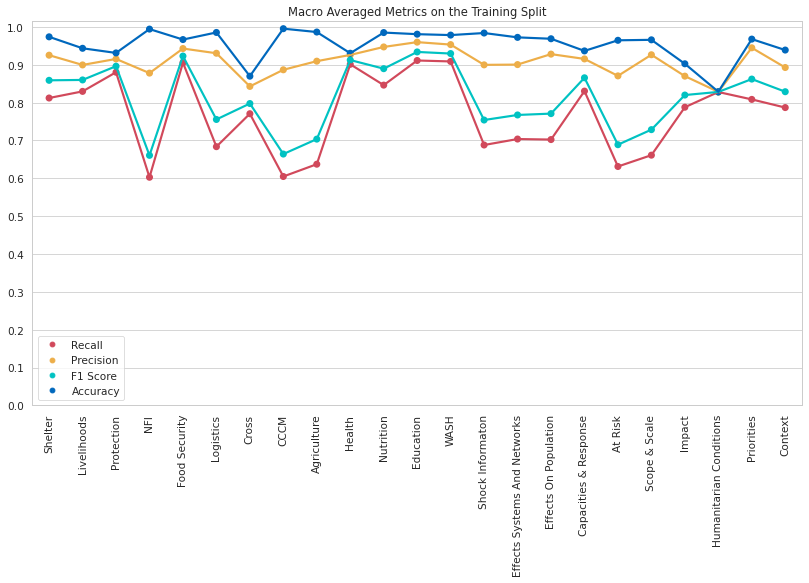

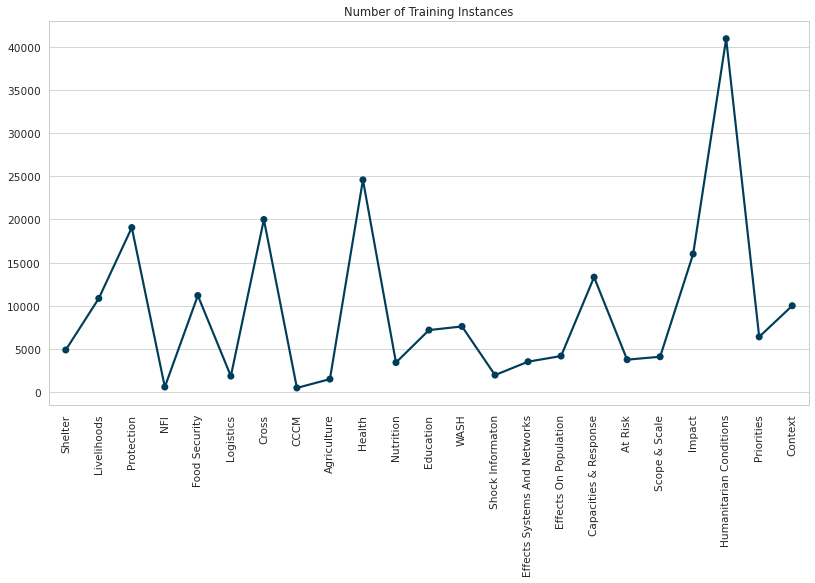

In [24]:
draw_metrics(metrics_train, "Training")
draw_supports(metrics_train, "Training")

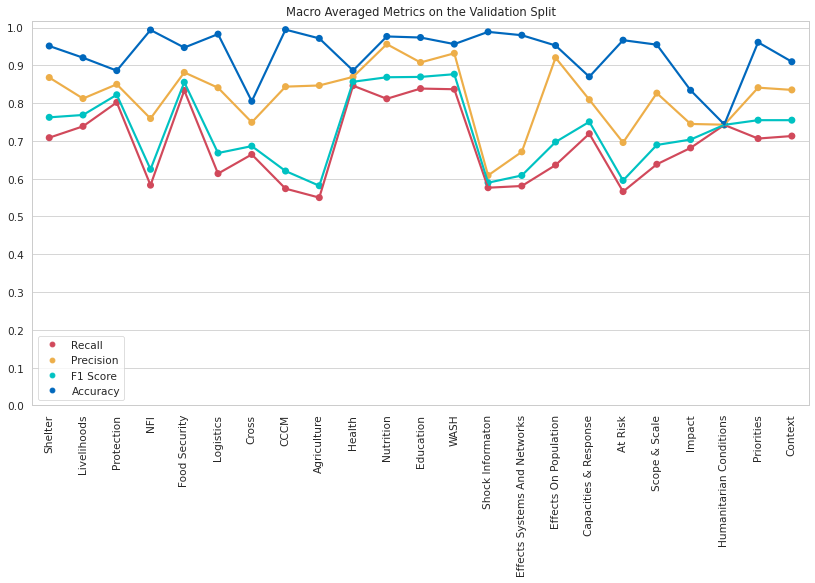

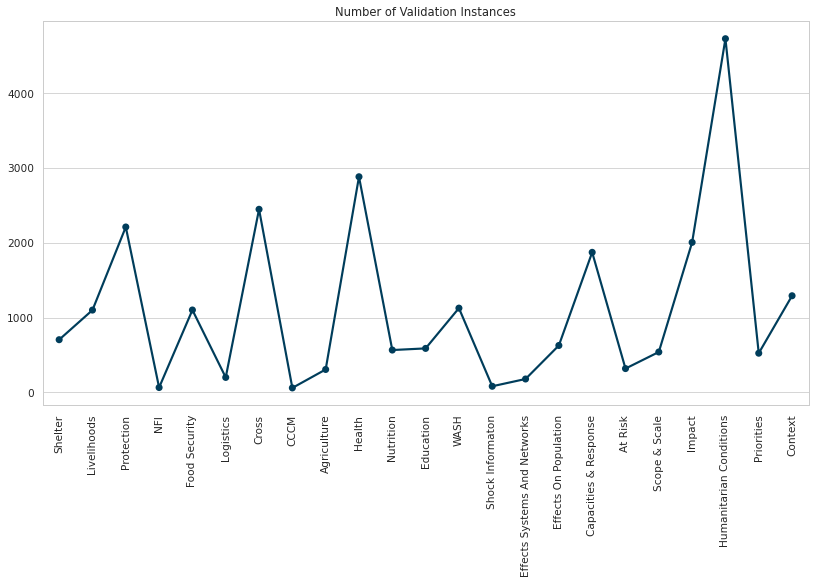

In [25]:
draw_metrics(metrics_val, "Validation")
draw_supports(metrics_val, "Validation")